# 03 – Model Evaluation and Reporting

In this notebook we:
- Re-load the processed modeling dataset
- Refit the Gradient Boosting model used in `02_modeling.ipynb`
- Compute accuracy, AUC, and Brier score on the test set
- Plot and save: confusion matrix, calibration curve, and ROC curve
- Generate markdown text to paste into the project README


In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    accuracy_score,
    confusion_matrix,
    RocCurveDisplay
)
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the figures folder exists
os.makedirs("reports/figures", exist_ok=True)

pd.set_option("display.max_columns", None)


In [8]:
# Load the processed dataset created in 01_data_processing.ipynb
df = pd.read_csv("../data/processed/matches_modeling_dataset.csv")

# Same feature set as notebook 02
feature_cols = [
    "temp",
    "humidity",
    "windspeed",
    "night_game",
    "travel_km",
    "home_not_home",
    "travel_outside_state",
    "attendance_ratio",
    "p_home_implied",
    "p_away_implied",
    "p_draw_implied",
]

target_col = "home_win"

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

X.head(), y.value_counts(normalize=True)


(   temp  humidity  windspeed  night_game  travel_km  home_not_home  \
 0  17.8        76       0.00           1        482              0   
 1  23.3        45       4.75           0        117              0   
 2  26.7        58       5.11           0        377              0   
 3  20.8        57       5.58           0        687              0   
 4  33.5        39       5.94           0        697              0   
 
    travel_outside_state  attendance_ratio  p_home_implied  p_away_implied  \
 0                     1          0.495060        0.729825        0.094400   
 1                     0          0.978489        0.873354        0.034475   
 2                     0          0.033437        0.707336        0.108631   
 3                     0          0.547429        0.323172        0.381130   
 4                     0          0.669318        0.521237        0.208548   
 
    p_draw_implied  
 0        0.175775  
 1        0.092171  
 2        0.184033  
 3        0.295699

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, confusion_matrix

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# model
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# predictions
y_pred = gb_clf.predict(X_test)
y_proba = gb_clf.predict_proba(X_test)[:, 1]


In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Brier Score:", brier_score_loss(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
cm


Accuracy: 0.7450980392156863
ROC AUC: 0.7534787612471228
Brier Score: 0.17533983875608092


array([[1050,  102],
       [ 327,  204]])

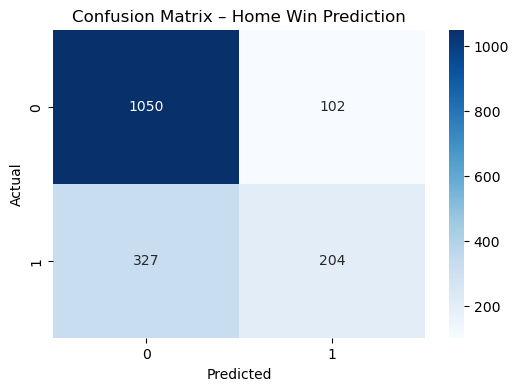

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Home Win Prediction")
plt.show()


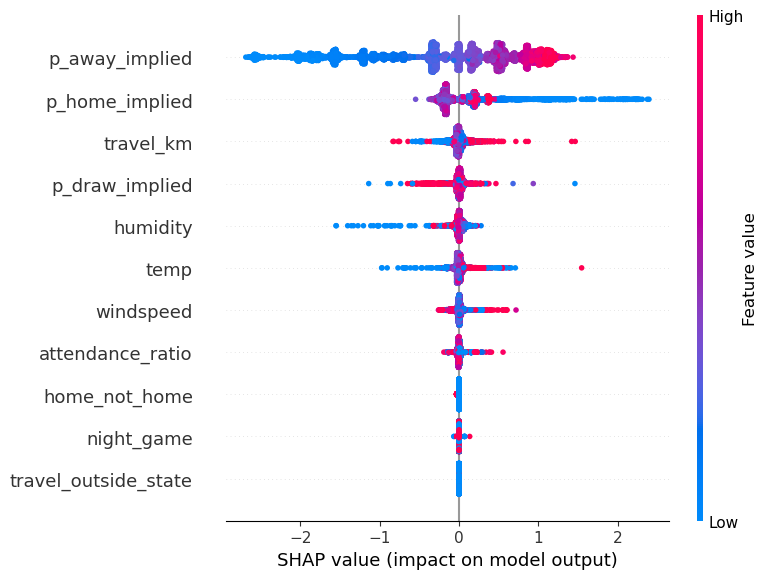

In [12]:
import shap
explainer = shap.TreeExplainer(gb_clf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
